**Import Libraries**

In [84]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sb
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from patsy import dmatrices
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from matplotlib.pyplot import figure

import statsmodels.api as sm

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")


import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA

<Figure size 1280x960 with 0 Axes>

**Import Dataset**

In [85]:
df = pd.read_excel("Airlines+Data.xlsx")
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


# EDA

In [86]:
df.shape

(96, 2)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [88]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [89]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

# Visualizations & Transformations

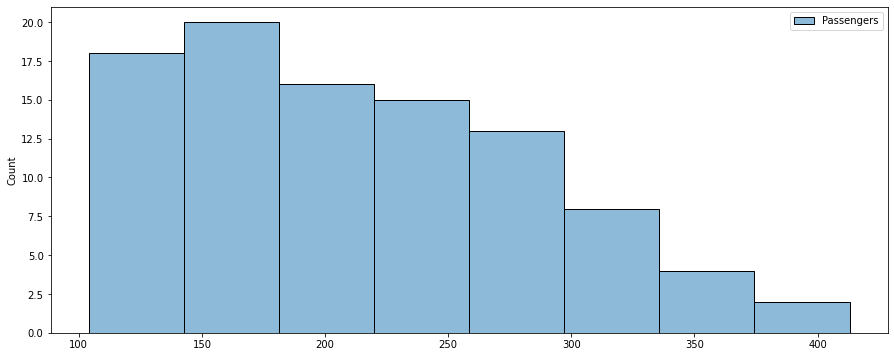

In [90]:
sb.histplot(df)
plt.show()

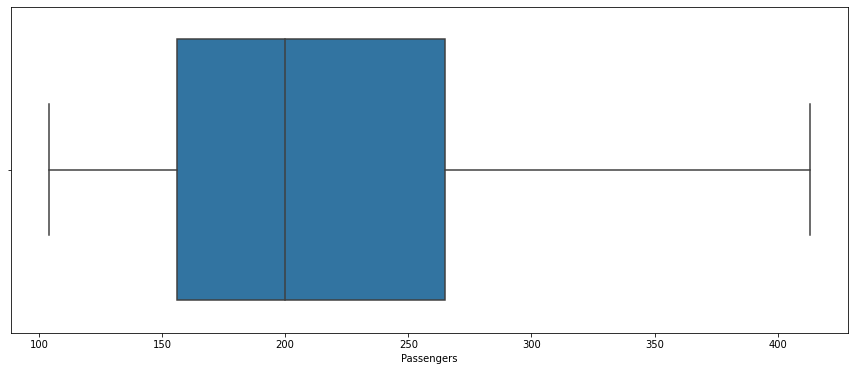

In [91]:
sb.boxplot(df['Passengers'])

In [92]:
# Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df = df.set_index(['Month'])

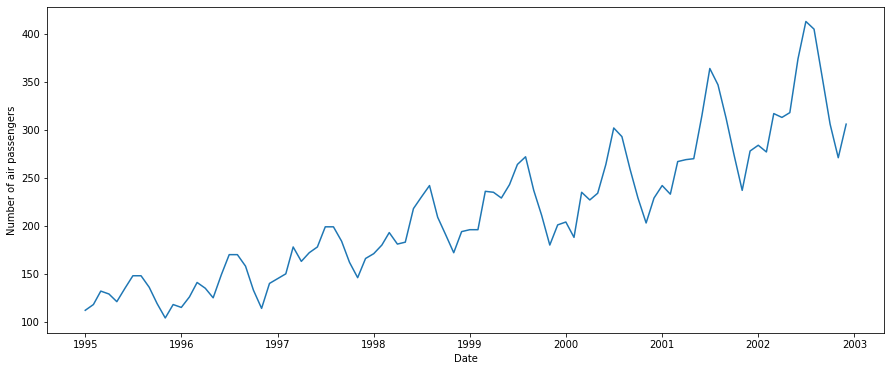

In [93]:
# plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

In [94]:
#Test whether Timeseries is Stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

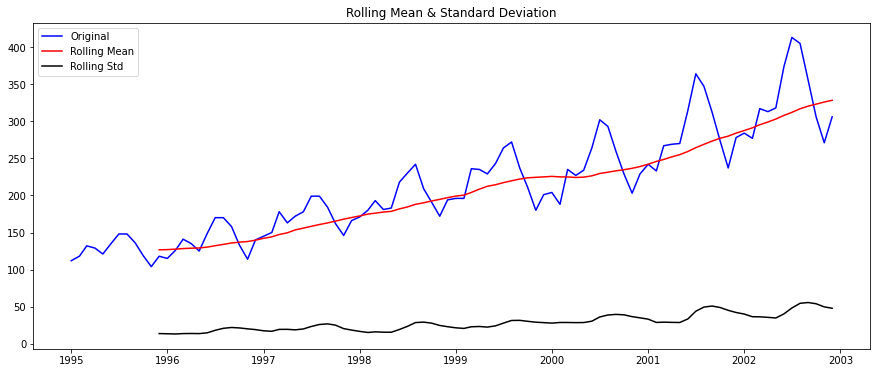

Results of Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [95]:
test_stationarity(df)

**From the above graph, we see that rolling mean has a trend component and rolling standard deviation is fairly constant with time. Critical values are no where close to the Test Statistics. Hence, we can say that our Time Series at the moment is not stationary**

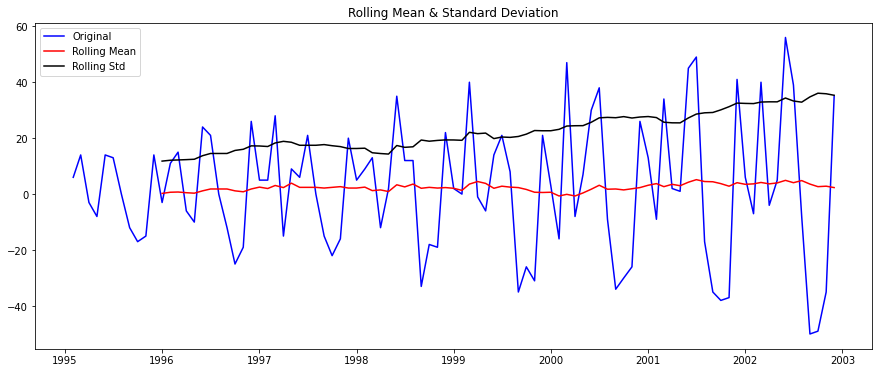

Results of Dickey-Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [96]:
df1 = df.diff(periods=1)
df1.dropna(inplace=True)
test_stationarity(df1)

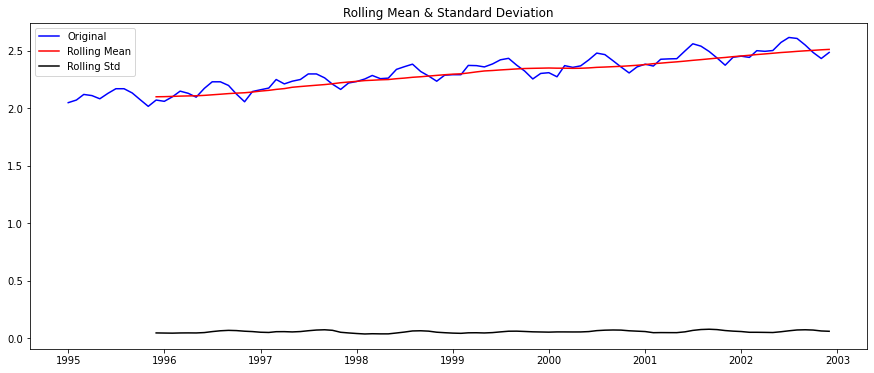

Results of Dickey-Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [97]:
df_log = np.log10(df)
df_log.dropna(inplace=True)
test_stationarity(df_log)

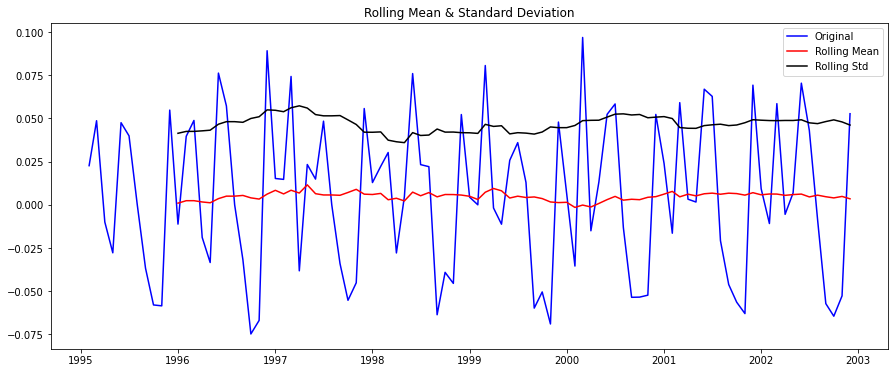

Results of Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [98]:
df_log_dif = df_log.diff(periods=1)
df_log_dif.dropna(inplace=True)
test_stationarity(df_log_dif)

**The rolling values appear to be varying slightly but there is no specific trend. The test statistic is smaller than the 10% critical values so we can say with 95% confidence that this is a stationary series**

# Time Series Decomposition

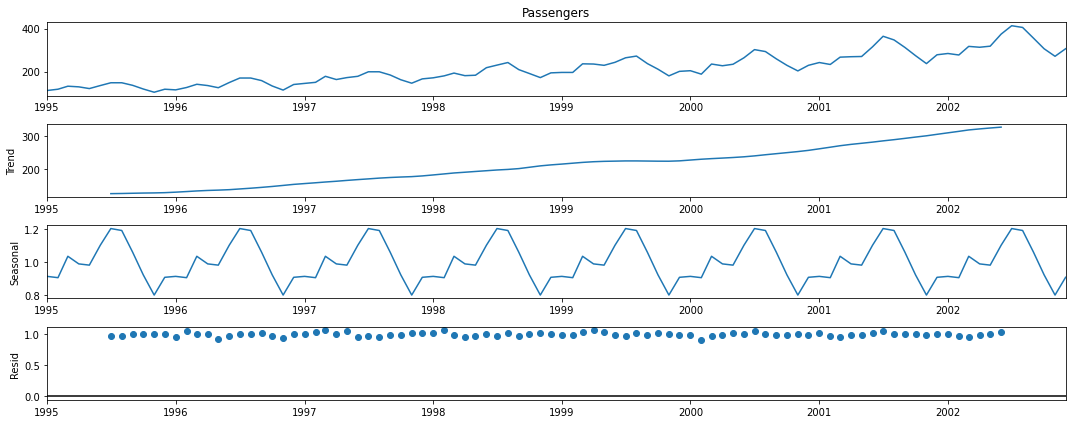

In [99]:
df_decompose = sm.tsa.seasonal_decompose(df['Passengers'], model="multiplicative", freq=12)
df_decompose.plot()
plt.show()

In [100]:
trend = df_decompose.trend
seasonal = df_decompose.seasonal
residual = df_decompose.resid

In [101]:
print("Trend \n",trend.head(24))
print("Seasonal \n",seasonal.head(24))
print("Residual \n",residual.head(24))

Trend 
 Month
1995-01-01           NaN
1995-02-01           NaN
1995-03-01           NaN
1995-04-01           NaN
1995-05-01           NaN
1995-06-01           NaN
1995-07-01    126.791667
1995-08-01    127.250000
1995-09-01    127.958333
1995-10-01    128.583333
1995-11-01    129.000000
1995-12-01    129.750000
1996-01-01    131.250000
1996-02-01    133.083333
1996-03-01    134.916667
1996-04-01    136.416667
1996-05-01    137.416667
1996-06-01    138.750000
1996-07-01    140.916667
1996-08-01    143.166667
1996-09-01    145.708333
1996-10-01    148.416667
1996-11-01    151.541667
1996-12-01    154.708333
Name: trend, dtype: float64
Seasonal 
 Month
1995-01-01    0.912588
1995-02-01    0.904717
1995-03-01    1.034182
1995-04-01    0.988112
1995-05-01    0.980616
1995-06-01    1.100952
1995-07-01    1.201996
1995-08-01    1.190208
1995-09-01    1.058383
1995-10-01    0.921785
1995-11-01    0.799500
1995-12-01    0.906962
1996-01-01    0.912588
1996-02-01    0.904717
1996-03-01    1.034

# Double Exponential (Holt)

In [107]:
train=df[0:int(len(df)*0.90)] 
test=df[int(len(df)*0.90):]
#Split the data for 21 month test

train_log = np.log10(train['Passengers'])

In [108]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [109]:
model_df = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=24, 
                                    trend='add',seasonal='mul').fit(optimized=True)

In [110]:
df_Holt = test.copy()
df_Holt['Holt']=model_df.forecast(len(test['Passengers']))
mean_absolute_percentage_error(test['Passengers'],df_Holt['Holt'])

3.4124132812951284

In [111]:
model_df.params

{'smoothing_level': 0.6811435158654962,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 0.0,
 'damping_trend': nan,
 'initial_level': 99.62405822379553,
 'initial_trend': 1.823163187967484,
 'initial_seasons': array([1.11407174, 1.09457402, 1.26359724, 1.22985141, 1.2113852 ,
        1.32558699, 1.4764548 , 1.43988273, 1.27789247, 1.11473716,
        0.95756583, 1.08808504, 1.09573565, 1.0694362 , 1.224684  ,
        1.15549181, 1.14816376, 1.31541647, 1.44817997, 1.43288644,
        1.25338356, 1.09750673, 0.96129643, 1.08726623]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

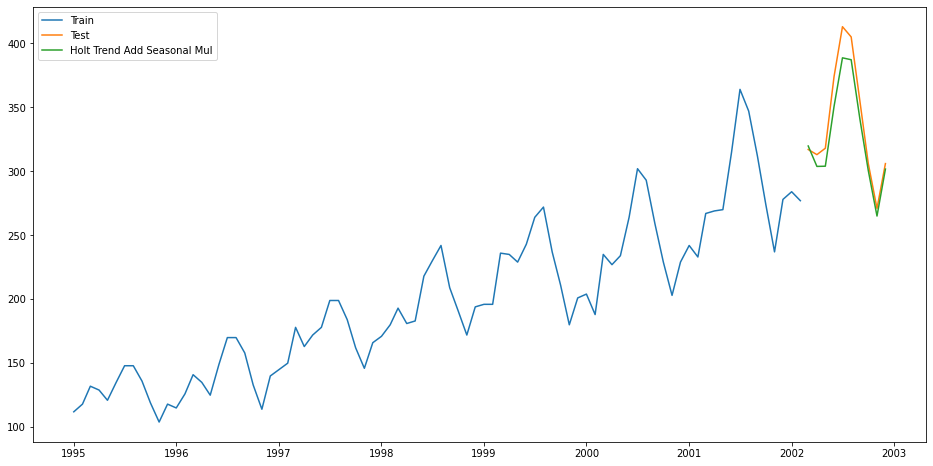

In [112]:
df_Holt['Pax'] = model_df.forecast(len(test['Passengers']))
plt.figure(figsize=(16,8))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(df_Holt['Holt'], label='Holt Trend Add Seasonal Mul')
plt.legend(loc=0)

# Plotting ACF & PCF



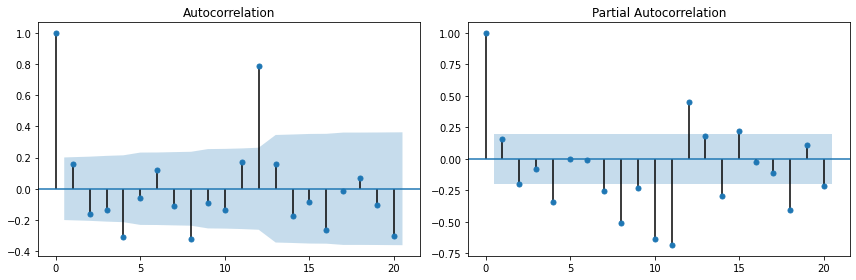

In [114]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df_log_dif, lags=20, ax=axes[0])
smt.graphics.plot_pacf(df_log_dif, lags=20, ax=axes[1])
plt.tight_layout()

# Building Models

In [115]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [116]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['Passengers'])

In [117]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-406.86343339814465


In [118]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,1),
                                seasonal_order=(1,0,1,12),
                                enforce_stationarity=True)

best_results = mod.fit()

print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3270      0.107     -3.061      0.002      -0.536      -0.118
ar.S.L12       0.9908      0.009    107.508      0.000       0.973       1.009
ma.S.L12      -0.6389      0.148     -4.317      0.000      -0.929      -0.349
sigma2         0.0003   5.09e-05      6.120      0.000       0.000       0.000


In [119]:
best_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.3270,0.107,-3.061,0.002,-0.536,-0.118
ar.S.L12,0.9908,0.009,107.508,0.000,0.973,1.009
ma.S.L12,-0.6389,0.148,-4.317,0.000,-0.929,-0.349
sigma2,0.0003,5.09e-05,6.120,0.000,0.000,0.000


In [120]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
pred99 = best_results.get_forecast(steps=24, alpha=0.1)
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['Passengers_Forecast'] = np.power(10, pred99.predicted_mean)

In [122]:
# Compute the root mean square error
mse = ((testCopy['Passengers'] - testCopy['Passengers_Forecast']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 8.013


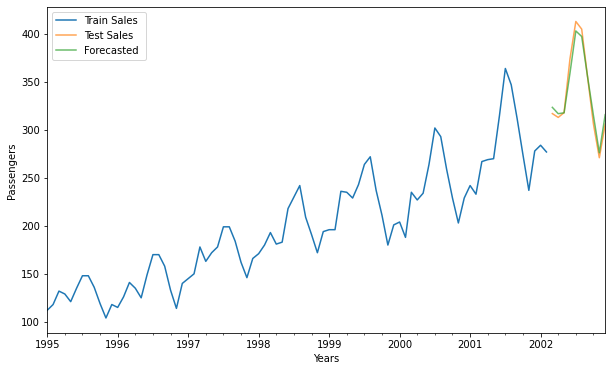

In [123]:
axis = train['Passengers'].plot(label='Train Sales', figsize=(10, 6))
testCopy['Passengers'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['Passengers_Forecast'].plot(ax=axis, label='Forecasted ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Passengers')
plt.legend(loc='best')
plt.show()
plt.close()

# ARIMA Model

In [124]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [126]:
n_steps = 36
idx = pd.date_range(df.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2002-12-01,323.491170,298.719099,350.317530,298.719099,350.317530
2003-01-01,316.890928,287.875666,348.830667,287.875666,348.830667
2003-02-01,317.798583,284.699852,354.745318,284.699852,354.745318
2003-03-01,359.031703,317.683641,405.761415,317.683641,405.761415
2003-04-01,403.124849,352.714997,460.739252,352.714997,460.739252


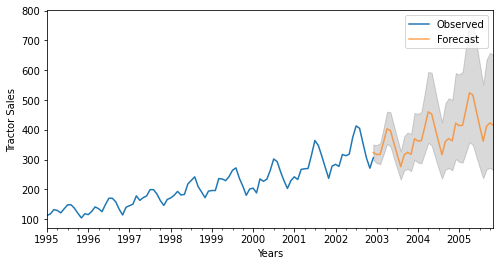

In [127]:
# plot the forecast along with the confidence band
axis = df['Passengers'].plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

**Plot ACF and PACF for residuals of ARIMA model**

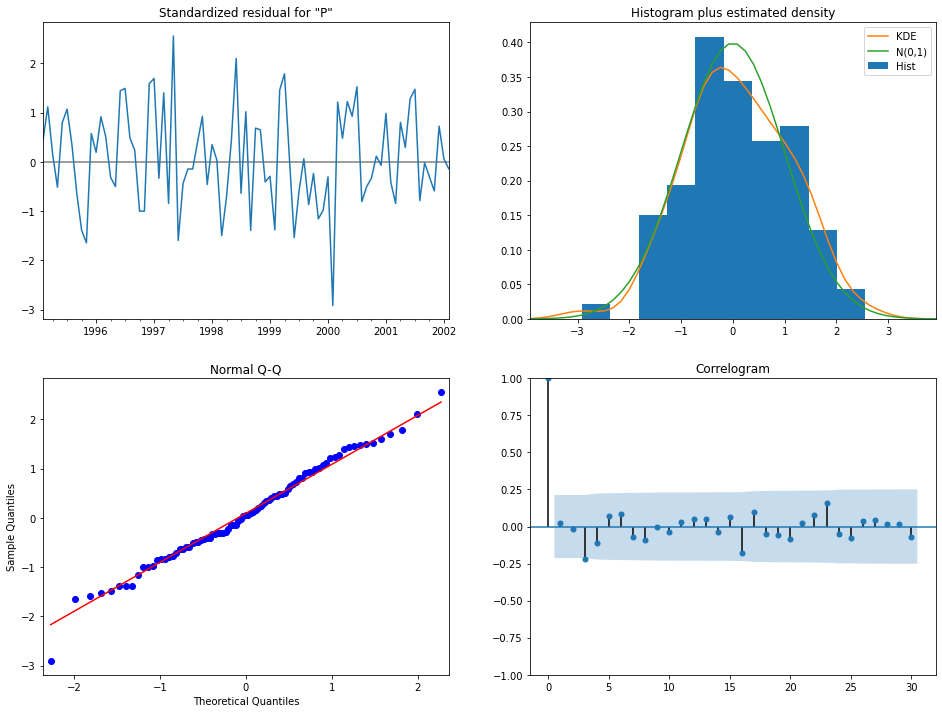

In [128]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()